In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from utils import *
from numpy.fft import fft2, ifft2, fftshift
from SALSA import CoRAL
import pywt

In [16]:
SNRdB = 40

In [17]:
img_ref = cv2.cvtColor( cv2.imread("images/cameraman.tif"), cv2.COLOR_BGR2GRAY)
M, N = img_ref.shape[:2]

In [18]:
h_blur = make_blur_kernel(51, M, blur_type=1)

HF = fft2(h_blur)

def A_op(x):
    YF = np.multiply(HF,fft2(x))
    y = np.real( ifft2(YF) )
    return y

def AT_op(x):
    YF = np.multiply(HF.conjugate(),fft2(x))
    y = np.real( ifft2(YF) )
    return y

In [19]:
y = A_op( addGaussianNoise(img_ref, SNRdB) )

In [20]:
Ax = A_op(img_ref)
sigma = np.sqrt( ((Ax-Ax.mean())**2).sum() )/np.sqrt( Ax.size*(10**(SNRdB/10))  )

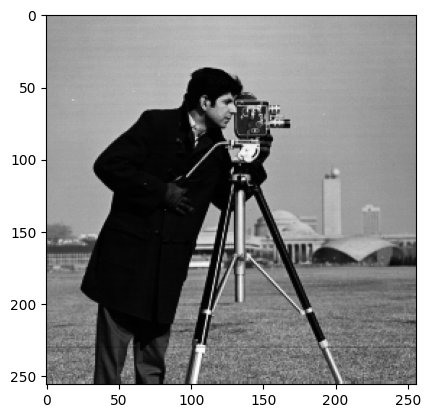

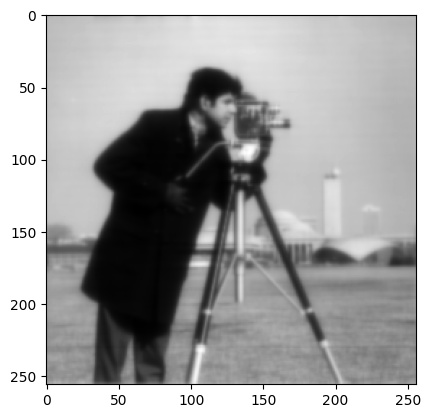

In [21]:
plt.figure(1)
plt.imshow(img_ref, cmap=plt.cm.gray)

plt.figure(2)
plt.imshow(y, cmap=plt.cm.gray)

In [22]:
num_levels = 3
wavelet_str = 'db2'

W = lambda x: wrapper_iswt2(x, wavelet_str, num_levels)
WT = lambda x: wrapper_swt2(x, wavelet_str, num_levels)

P = lambda x: wrapper_iswt2(x, wavelet_str, num_levels)
PT = lambda x: wrapper_swt2(x, wavelet_str, num_levels)

In [23]:
tau1 = 0.0025
mu1 = tau1/10

tau2 = 0.007
mu2 = tau2/10

P2 = lambda x: WT(P(x))
P2T = lambda x: PT(W(x))

H2 = np.abs(HF)**2

def invLS(x, mu1, mu2):
    alpha = mu1 + mu2
    mu1inv = 1/mu1
    alphainv = 1/alpha
    filter_FFT = np.divide( (H2+mu2), (H2 + alpha) )
    return mu1inv*( x - WT( np.real( ifft2( np.multiply( filter_FFT,fft2( W(x) ) ) ) ) ) )

A = lambda x: A_op( W(x) )
AT = lambda x: WT( AT_op(x) )

In [24]:
coral_obj = CoRAL( y, A=A, AT=AT, invLS=invLS, tau1=tau1, tau2=tau2,\
                 mu1=mu1, mu2=mu2, P2=P2, P2T=P2T, W=W, WT=WT)

In [25]:
x, objective, times, distance1, distance2, numA, numAt = coral_obj.predict(y,\
                                                                            tau1=tau1, tau2=tau2,\
                                                                            mu1 = mu1, mu2 = mu2,\
                                                                            stopCriterion=1,\
                                                                            x_init=2, MaxIt=100,\
                                                                            tolA=0.01, verbose=0)

Convergence reached.


In [26]:
x_out = W(x)
print ("ISNR is ",myISNR(img_ref,y,x_out ))

ISNR is  16.498749774545626


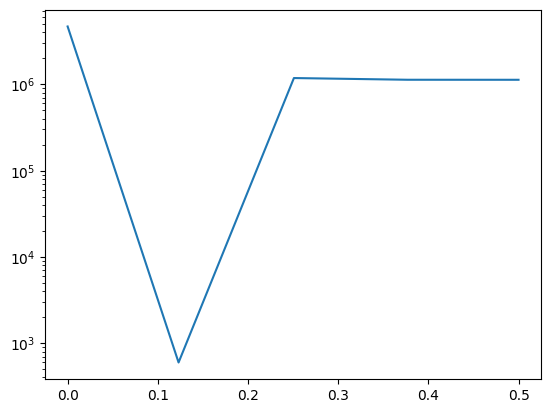

In [27]:
plt.semilogy(times,objective)
plt.show()

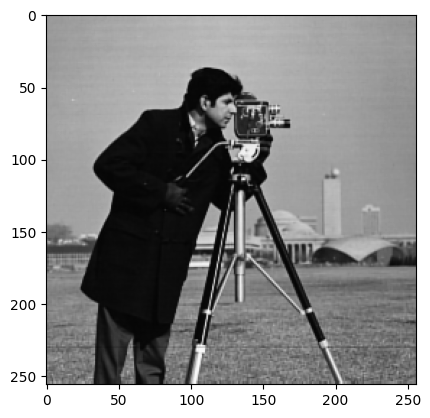

In [28]:
plt.imshow(x_out, cmap=plt.cm.gray)
plt.show()